## Código Básico

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

## Glassdoor

#### Tentativa normal

In [38]:
# import requests
# from fake_useragent import UserAgent

# ua = UserAgent()
# headers = {
#     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
# }

# url ="https://www.glassdoor.com.br/Avalia%C3%A7%C3%B5es/ibis-Avalia%C3%A7%C3%B5es-E1443740.htm"

# response = requests.get(url, headers=headers)
# print(response.text)

# #soup = BeautifulSoup(response.text, 'html')

# # find description in the HTML:
# #print(soup.find_all('div'))

# # div class="review-details_topReview__BIP4D"

#### Scrapfly

In [2]:
"""
This is an example web scraper for Glassdoor.com used in scrapfly blog article:
https://scrapfly.io/blog/how-to-scrape-glassdoor/

To run this scraper set env variable $SCRAPFLY_KEY with your scrapfly API key:
$ export $SCRAPFLY_KEY="your key from https://scrapfly.io/dashboard"
"""
from enum import Enum
import json
import os
import re
from typing import Dict, List, Optional, Tuple, TypedDict
from urllib.parse import urljoin

from loguru import logger as log
from scrapfly import ScrapeApiResponse, ScrapeConfig, ScrapflyClient, ScrapflyScrapeError

SCRAPFLY = ScrapflyClient(key='scp-live-c6bc397cc2884718910b12838ab40894')
BASE_CONFIG = {
    # Glassdoor.com requires Anti Scraping Protection bypass feature.
    # for more: https://scrapfly.io/docs/scrape-api/anti-scraping-protection
    "asp": True,
    "country": "BR",
}

#os.environ["SCRAPFLY_KEY"]

In [3]:
def find_hidden_data(result: ScrapeApiResponse) -> dict:
    """
    Extract hidden web cache (Apollo Graphql framework) from Glassdoor page HTML
    It's either in NEXT_DATA script or direct apolloState js variable
    """
    # data can be in __NEXT_DATA__ cache
    data = result.selector.css("script#__NEXT_DATA__::text").get()
    if data:
        data = json.loads(data)["props"]["pageProps"]["apolloCache"]
    else:  # or in direct apolloState cache
        data = re.findall(r'apolloState":\s*({.+})};', result.content)[0]
        data = json.loads(data)

    def _unpack_apollo_data(apollo_data):
        """
        Glassdoor uses Apollo GraphQL client and the dataset is a graph of references.
        This function unpacks the __ref references to actual values.
        """

        def resolve_refs(data, root):
            if isinstance(data, dict):
                if "__ref" in data:
                    return resolve_refs(root[data["__ref"]], root)
                else:
                    return {k: resolve_refs(v, root) for k, v in data.items()}
            elif isinstance(data, list):
                return [resolve_refs(i, root) for i in data]
            else:
                return data

        return resolve_refs(apollo_data.get("ROOT_QUERY") or apollo_data, apollo_data)

    return _unpack_apollo_data(data)


def parse_jobs(result: ScrapeApiResponse) -> Tuple[List[Dict], List[str]]:
    """Parse Glassdoor jobs page for job data and other page pagination urls"""
    cache = find_hidden_data(result)
    job_cache = next(v for k, v in cache.items() if k.startswith("jobListings"))
    jobs = [v["jobview"]["header"] for v in job_cache["jobListings"]]
    other_pages = [
        urljoin(result.context["url"], page["urlLink"])
        for page in job_cache["paginationLinks"]
        if page["isCurrentPage"] is False
    ]
    return jobs, other_pages


async def scrape_jobs(url: str, max_pages: Optional[int] = None) -> List[Dict]:
    """Scrape Glassdoor job listing page for job listings (with pagination)"""
    log.info("scraping job listings from {}", url)
    first_page = await SCRAPFLY.async_scrape(ScrapeConfig(url, **BASE_CONFIG))

    jobs, other_page_urls = parse_jobs(first_page)
    _total_pages = len(other_page_urls) + 1
    if max_pages and _total_pages > max_pages:
        other_page_urls = other_page_urls[:max_pages]

    log.info("scraped first page of jobs of {}, scraping remaining {} pages", url, _total_pages - 1)
    other_pages = [ScrapeConfig(url, **BASE_CONFIG) for url in other_page_urls]
    async for result in SCRAPFLY.concurrent_scrape(other_pages):
        if not isinstance(result, ScrapflyScrapeError):
            jobs.extend(parse_jobs(result)[0])
        else:
            log.error(f"failed to scrape {result.api_response.config['url']}, got: {result.message}")
    log.info("scraped {} jobs from {} in {} pages", len(jobs), url, _total_pages)
    return jobs


def parse_reviews(result: ScrapeApiResponse) -> Dict:
    """parse Glassdoor reviews page for review data"""
    cache = find_hidden_data(result)
    reviews = next(v for k, v in cache.items() if k.startswith("employerReviews") and v.get("reviews"))
    return reviews


async def scrape_reviews(url: str, max_pages: Optional[int] = None) -> Dict:
    """Scrape Glassdoor reviews listings from reviews page (with pagination)"""
    log.info("scraping reviews from {}", url)
    first_page = await SCRAPFLY.async_scrape(ScrapeConfig(url=url, **BASE_CONFIG))

    reviews = parse_reviews(first_page)
    total_pages = reviews["numberOfPages"]
    if max_pages and max_pages < total_pages:
        total_pages = max_pages

    log.info("scraped first page of reviews of {}, scraping remaining {} pages", url, total_pages - 1)
    other_pages = [
        ScrapeConfig(url=Url.change_page(first_page.context["url"], page=page), **BASE_CONFIG)
        for page in range(2, total_pages + 1)
    ]
    async for result in SCRAPFLY.concurrent_scrape(other_pages):
        if not isinstance(result, ScrapflyScrapeError):
            reviews["reviews"].extend(parse_reviews(result)["reviews"])
        else:
            log.error(f"failed to scrape {result.api_response.config['url']}, got: {result.message}")
    log.info("scraped {} reviews from {} in {} pages", len(reviews["reviews"]), url, total_pages)
    return reviews


def parse_salaries(result: ScrapeApiResponse) -> Dict:
    """Parse Glassdoor salaries page for salary data"""
    cache = find_hidden_data(result)
    salaries = next(v for k, v in cache.items() if k.startswith("aggregatedSalaryEstimates") and v.get("results"))
    return salaries


async def scrape_salaries(url: str, max_pages: Optional[int] = None) -> Dict:
    """Scrape Glassdoor Salary page for salary listing data (with pagination)"""
    log.info("scraping salaries from {}", url)
    first_page = await SCRAPFLY.async_scrape(ScrapeConfig(url=url, **BASE_CONFIG))
    salaries = parse_salaries(first_page)
    total_pages = salaries["numPages"]
    if max_pages and total_pages > max_pages:
        total_pages = max_pages

    log.info("scraped first page of salaries of {}, scraping remaining {} pages", url, total_pages - 1)
    other_pages = [
        ScrapeConfig(url=Url.change_page(first_page.context["url"], page=page), **BASE_CONFIG)
        for page in range(2, total_pages + 1)
    ]
    async for result in SCRAPFLY.concurrent_scrape(other_pages):
        if not isinstance(result, ScrapflyScrapeError):
            salaries["results"].extend(parse_salaries(result)["results"])
        else:
            log.error(f"failed to scrape {result.api_response.config['url']}, got: {result.message}")
    log.info("scraped {} salaries from {} in {} pages", len(salaries["results"]), url, total_pages)
    return salaries


class FoundCompany(TypedDict):
    """type hint for company search result"""
    name: str
    id: str
    url_overview: str
    url_jobs: str
    url_reviews: str
    url_salaries: str


async def find_companies(query: str) -> List[FoundCompany]:
    """find company Glassdoor ID and name by query. e.g. "ebay" will return "eBay" with ID 7853"""
    result = await SCRAPFLY.async_scrape(
        ScrapeConfig(
            url=f"https://www.glassdoor.com/searchsuggest/typeahead?numSuggestions=8&source=GD_V2&version=NEW&rf=full&fallback=token&input={query}",
            **BASE_CONFIG,
        )
    )
    data = json.loads(result.content)
    companies = []
    for result in data:
        if result["category"] == "company":
            companies.append(
                {
                    "name": result["suggestion"],
                    "id": result["employerId"],
                    "url_overview": Url.overview(result["suggestion"], result["employerId"]),
                    "url_jobs": Url.jobs(result["suggestion"], result["employerId"]),
                    "url_reviews": Url.reviews(result["suggestion"], result["employerId"]),
                    "url_salaries": Url.salaries(result["suggestion"], result["employerId"]),
                }
            )
    return companies


class Region(Enum):
    """glassdoor.com region codes"""

    UNITED_STATES = "1"
    UNITED_KINGDOM = "2"
    CANADA_ENGLISH = "3"
    INDIA = "4"
    AUSTRALIA = "5"
    FRANCE = "6"
    GERMANY = "7"
    SPAIN = "8"
    BRAZIL = "9"
    NETHERLANDS = "10"
    AUSTRIA = "11"
    MEXICO = "12"
    ARGENTINA = "13"
    BELGIUM_NEDERLANDS = "14"
    BELGIUM_FRENCH = "15"
    SWITZERLAND_GERMAN = "16"
    SWITZERLAND_FRENCH = "17"
    IRELAND = "18"
    CANADA_FRENCH = "19"
    HONG_KONG = "20"
    NEW_ZEALAND = "21"
    SINGAPORE = "22"
    ITALY = "23"


class Url:
    """
    Helper URL generator that generates full URLs for glassdoor.com pages
    from given employer name and ID
    For example:
    > GlassdoorUrl.overview("eBay Motors Group", "4189745")
    https://www.glassdoor.com/Overview/Working-at-eBay-Motors-Group-EI_IE4189745.11,28.htm

    Note that URL formatting is important when it comes to scraping Glassdoor
    as unusual URL formats can lead to scraper blocking.
    """

    @staticmethod
    def overview(employer: str, employer_id: str, region: Optional[Region] = None) -> str:
        employer = employer.replace(" ", "-")
        url = f"https://www.glassdoor.com/Overview/Working-at-{employer}-EI_IE{employer_id}"
        # glassdoor is allowing any prefix for employer name and
        # to indicate the prefix suffix numbers are used like:
        # https://www.glassdoor.com/Overview/Working-at-eBay-Motors-Group-EI_IE4189745.11,28.htm
        # 11,28 is the slice where employer name is
        _start = url.split("/Overview/")[1].find(employer)
        _end = _start + len(employer)
        url += f".{_start},{_end}.htm"
        if region:
            return url + f"?filter.countryId={region.value}"
        return url

    @staticmethod
    def reviews(employer: str, employer_id: str, region: Optional[Region] = None) -> str:
        employer = employer.replace(" ", "-")
        url = f"https://www.glassdoor.com/Reviews/{employer}-Reviews-E{employer_id}.htm?"
        if region:
            return url + f"?filter.countryId={region.value}"
        return url

    @staticmethod
    def salaries(employer: str, employer_id: str, region: Optional[Region] = None) -> str:
        employer = employer.replace(" ", "-")
        url = f"https://www.glassdoor.com/Salary/{employer}-Salaries-E{employer_id}.htm?"
        if region:
            return url + f"?filter.countryId={region.value}"
        return url

    @staticmethod
    def jobs(employer: str, employer_id: str, region: Optional[Region] = None) -> str:
        employer = employer.replace(" ", "-")
        url = f"https://www.glassdoor.com/Jobs/{employer}-Jobs-E{employer_id}.htm?"
        if region:
            return url + f"?filter.countryId={region.value}"
        return url

    @staticmethod
    def change_page(url: str, page: int) -> str:
        """update page number in a glassdoor url"""
        if re.search(r"_P\d+\.htm", url):
            new = re.sub(r"(?:_P\d+)*.htm", f"_P{page}.htm", url)
        else:
            new = re.sub(".htm", f"_P{page}.htm", url)
        assert new != url
        return new

In [6]:
# Import the necessary modules
import asyncio

# Define your search query
query = "ibis"  # Replace with the company you are interested in

# Find the company
async def get_company_info(query: str):
    companies = await find_companies(query)
    if companies:
        return companies[0]  # Get the first match
    else:
        raise ValueError("No company found")

# Run the function in the existing event loop
company_info = await get_company_info(query)
print(company_info)

{'name': 'IBIS', 'id': '1443740', 'url_overview': 'https://www.glassdoor.com/Overview/Working-at-IBIS-EI_IE1443740.11,15.htm', 'url_jobs': 'https://www.glassdoor.com/Jobs/IBIS-Jobs-E1443740.htm?', 'url_reviews': 'https://www.glassdoor.com/Reviews/IBIS-Reviews-E1443740.htm?', 'url_salaries': 'https://www.glassdoor.com/Salary/IBIS-Salaries-E1443740.htm?'}


In [7]:
# Define the URL for reviews based on the company_info obtained
company_id = company_info["id"]
reviews_url = Url.reviews(company_info["name"], company_id)

# Scrape the reviews
async def get_reviews(url: str):
    reviews = await scrape_reviews(url)
    return reviews

# Run the function to get reviews
reviews_data = await get_reviews(reviews_url)
#print(reviews_data)

2024-10-03 22:38:15.359 | INFO     | __main__:scrape_reviews:79 - scraping reviews from https://www.glassdoor.com/Reviews/IBIS-Reviews-E1443740.htm?
2024-10-03 22:38:35.176 | INFO     | __main__:scrape_reviews:87 - scraped first page of reviews of https://www.glassdoor.com/Reviews/IBIS-Reviews-E1443740.htm?, scraping remaining 26 pages
2024-10-03 22:41:02.546 | INFO     | __main__:scrape_reviews:97 - scraped 265 reviews from https://www.glassdoor.com/Reviews/IBIS-Reviews-E1443740.htm? in 27 pages


In [8]:
from pprint import pprint
pprint(reviews_data,  indent=4)

{   '__typename': 'EmployerReviewsRG',
    'allReviewsCount': 844,
    'currentPage': 1,
    'filteredReviewsCount': 265,
    'lastReviewDateTime': '2024-09-23T20:01:15.310',
    'numberOfPages': 27,
    'queryJobTitle': None,
    'queryLocation': None,
    'ratedReviewsCount': 716,
    'ratingCountDistribution': {   '__typename': 'RatingCountDistribution',
                                   'careerOpportunities': {   '_1': 79,
                                                              '_2': 102,
                                                              '_3': 127,
                                                              '_4': 129,
                                                              '_5': 146,
                                                              '__typename': 'FiveStarRatingCountDistribution'},
                                   'compensationAndBenefits': {   '_1': 79,
                                                                  '_2': 104,
           

                                                                           'jobCount': 71},
                                                     'interviewCount': 77,
                                                     'photoCount': 4,
                                                     'reviewCount': 844,
                                                     'salaryCount': 1371},
                                       'coverPhoto': {   '__typename': 'EmployerCoverPhoto',
                                                         'hiResUrl': None},
                                       'employerManagedContent({"parameters":[{"divisionProfileId":8038705,"employerId":1443740}]})': [   {   '__typename': 'EmployerManagedContent',
                                                                                                                                              'diversityContent': {   '__typename': 'DiversityAndInclusionContent',
                                                    

                       'summaryOriginal': None,
                       'translationMethod': None},
                   {   '__typename': 'EmployerReviewRG',
                       'advice': 'Invista sempre mais em oportunidades de '
                                 'crescimento para os funcionários que querem '
                                 'seguir carreira',
                       'adviceOriginal': None,
                       'cons': 'Por se tratar de uma rede econômica. Buscam a '
                               'redução de gastos em toda a parte. Seja na '
                               'quantidade de funcionários ou de produtos para '
                               'a venda no hotel.',
                       'consOriginal': None,
                       'countHelpful': 0,
                       'countNotHelpful': 0,
                       'employer': {   '__typename': 'Employer',
                                       'activeStatus': 'INACTIVE',
                                   

                       'employer': {   '__typename': 'Employer',
                                       'activeStatus': 'INACTIVE',
                                       'approvalStatus': 'APPROVED',
                                       'bestLedCompanies({"onlyCurrent":true})': [   ],
                                       'bestPlacesToWork({"onlyCurrent":true})': [   ],
                                       'bestProfile': {   '__typename': 'EmployerProfile',
                                                          'id': 8038705,
                                                          'rowProfile': False},
                                       'counts': {   '__typename': 'EmployerCounts',
                                                     'benefitCount': 154,
                                                     'globalJobCount': {   '__typename': 'EmployerJobCountHolder',
                                                                           'jobCount': 71},
             

In [10]:
# Listas para armazenar os dados de cada busca
review_ids = []
contras = []
pros = []
cidades = []
jobtitles = []
rating_business_outlook = []
rating_career_opportunities = []
rating_ceo = []
rating_compensation_and_benefits = []
rating_culture_and_values = []
rating_diversity_and_inclusion = []
rating_overall = []
rating_recommend_to_friend = []
rating_senior_leadership = []
rating_work_life_balance = []
review_date_time = []
summaries = []

# Loop para extrair os dados
for n in range(0, 263):
    try:
        # Verifica se todos os campos existem e são válidos antes de adicionar
        
        review_id = reviews_data['reviews'][n].get('reviewId', None)
        contra = reviews_data['reviews'][n].get('cons', None)
        pro = reviews_data['reviews'][n].get('pros', None)
        
         # Verifica se 'location' e 'name' existem
        if reviews_data['reviews'][n].get('location') is not None:
            cidade = reviews_data['reviews'][n]['location'].get('name', None)
        else:
            cidade = None
    
        # Verifica se 'jobTitle' e 'text' existem
        if reviews_data['reviews'][n].get('jobTitle') is not None:
            jobtitle = reviews_data['reviews'][n]['jobTitle'].get('text', None)
        else:
            jobtitle = None
        
        
        rating_business = reviews_data['reviews'][n].get('ratingBusinessOutlook', None)
        rating_career = reviews_data['reviews'][n].get('ratingCareerOpportunities', None)
        rating_ceo_ = reviews_data['reviews'][n].get('ratingCeo', None)
        rating_compensation = reviews_data['reviews'][n].get('ratingCompensationAndBenefits', None)
        rating_culture = reviews_data['reviews'][n].get('ratingCultureAndValues', None)
        rating_diversity = reviews_data['reviews'][n].get('ratingDiversityAndInclusion', None)
        rating_overall_ = reviews_data['reviews'][n].get('ratingOverall', None)
        rating_recommend = reviews_data['reviews'][n].get('ratingRecommendToFriend', None)
        rating_senior = reviews_data['reviews'][n].get('ratingSeniorLeadership', None)
        rating_worklife = reviews_data['reviews'][n].get('ratingWorkLifeBalance', None)
        review_date = reviews_data['reviews'][n].get('reviewDateTime', None)
        summary_ = reviews_data['reviews'][n].get('summary', None)

        # Adiciona os dados em todas as listas para garantir que elas tenham o mesmo tamanho
        review_ids.append(review_id)
        contras.append(contra)
        pros.append(pro)
        cidades.append(cidade)
        jobtitles.append(jobtitle)
        rating_business_outlook.append(rating_business)
        rating_career_opportunities.append(rating_career)
        rating_ceo.append(rating_ceo_)
        rating_compensation_and_benefits.append(rating_compensation)
        rating_culture_and_values.append(rating_culture)
        rating_diversity_and_inclusion.append(rating_diversity)
        rating_overall.append(rating_overall_)
        rating_recommend_to_friend.append(rating_recommend)
        rating_senior_leadership.append(rating_senior)
        rating_work_life_balance.append(rating_worklife)
        review_date_time.append(review_date)
        summaries.append(summary_)
        
    except KeyError as e:
        print(f"Erro na entrada {n}: {e}")

# Certifique-se de que todas as listas tenham o mesmo tamanho
print(len(review_ids), len(contras), len(pros), len(cidades), len(jobtitles), len(rating_business_outlook),
len(rating_career_opportunities), len(rating_ceo), len(rating_compensation_and_benefits), len(rating_culture_and_values),
len(rating_diversity_and_inclusion), len(rating_overall), len(rating_recommend_to_friend), len(rating_senior_leadership),
len(rating_work_life_balance), len(review_date_time), len(summaries))


# Criar df
df = pd.DataFrame({
    'Review ID': review_ids,
    'Contras': contras,
    'Pros': pros,
    'Cidade': cidades,
    'Job Title': jobtitles,
    'Rating Business Outlook': rating_business_outlook,
    'Rating Career Opportunities': rating_career_opportunities,
    'Rating CEO': rating_ceo,
    'Rating Compensation and Benefits': rating_compensation_and_benefits,
    'Rating Culture and Values': rating_culture_and_values,
    'Rating Diversity and Inclusion': rating_diversity_and_inclusion,
    'Rating Overall': rating_overall,
    'Rating Recommend to Friend': rating_recommend_to_friend,
    'Rating Senior Leadership': rating_senior_leadership,
    'Rating Work Life Balance': rating_work_life_balance,
    'Review Date Time': review_date_time,
    'Summary': summaries
})

263 263 263 263 263 263 263 263 263 263 263 263 263 263 263 263 263


In [11]:
df

,Review ID,Contras,Pros,Cidade,Job Title,Rating Business Outlook,Rating Career Opportunities,Rating CEO,Rating Compensation and Benefits,Rating Culture and Values,Rating Diversity and Inclusion,Rating Overall,Rating Recommend to Friend,Rating Senior Leadership,Rating Work Life Balance,Review Date Time,Summary
0,90403207,Não encontrei nenhum ponto negativo,Benefícios e plano de carreira,"São Paulo, SP",Coordenador De Alimentos E Bebidas,POSITIVE,5,None,5,5,5,5,POSITIVE,5,5,2024-08-25T14:33:31.713,Muito bom
1,91283052,"Empresa tóxica, sobrecarregado todos os funcio...","Nenhum, o único que era pra ser um ""benefício""...",None,Auxiliar De Cozinha,NEGATIVE,1,None,1,1,5,1,NEGATIVE,1,1,2024-09-23T20:01:15.310,Pior experiência de trabalho da minha vida
2,91215634,Salário de estágio bem baixo,"Local tranquilo para trabalhar, não tive probl...",Rio de Janeiro,Estagiário,NEGATIVE,3,None,2,4,4,3,NEGATIVE,4,4,2024-09-21T05:15:50.900,A
3,90858172,"exige mais que o esperado, tem que ter muita p...",A hotelaria e uma excelente área para quem des...,Barretos,Atendente De Hospedagem,NEUTRAL,2,None,4,4,5,4,POSITIVE,3,2,2024-09-09T17:44:28.277,"Uma área boa, mas que exige paciência"
4,90127755,No meu cargo salario e baixo e trabalha bastante,"Ótimo ambiente de trabalho, oportunidade de cr...",São José dos Pinhais,Atendente De AeB,None,0,None,0,0,0,5,None,0,0,2024-08-15T12:53:26.963,Salario
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,83860934,"Apesar da maioria ser bem comprometida, as vez...","Pessoas comprometidas, ambiente agradável e be...",None,Recepcionista De Hotel,NEUTRAL,5,None,4,4,5,5,POSITIVE,4,4,2024-01-30T01:30:13.677,ótimo
259,86699839,"Pouca mão de obra, o que deixa os funcionários...","Salário competitivo, liberdade para trabalhar,...",None,Auditor Noturno,POSITIVE,3,None,4,1,4,4,POSITIVE,1,2,2024-04-25T21:17:43.470,Boa pra quem gosta de agito
260,86683946,sem benefícios na empresa atualmente,bom salário otimo ambiente qualidade,None,Analista De Qualidade,None,0,None,0,0,0,5,None,0,0,2024-04-25T10:52:16.573,boa
261,86271191,"Fica em pé na recepção o dia inteiro,escala de...","Salário,Plano de Saúde,Flash, Alimentação boa",Rio de Janeiro,Recepção,None,5,None,5,5,5,5,None,5,5,2024-04-12T18:44:59.087,Bom


In [4]:
# Salvar dados do Glassdoor do Ibis
df.to_excel('dados_galssdoor_ibis.xlsx', index=False)

## Carregar dados

In [3]:
import pandas as pd

df_ = pd.read_excel('dados_galssdoor_ibis.xlsx', sheet_name='Sheet1')
df_ = df_.drop(['Rating CEO'], axis=1)

In [4]:
df_

,Review ID,Contras,Pros,Cidade,Job Title,Rating Business Outlook,Rating Career Opportunities,Rating Compensation and Benefits,Rating Culture and Values,Rating Diversity and Inclusion,Rating Overall,Rating Recommend to Friend,Rating Senior Leadership,Rating Work Life Balance,Review Date Time,Summary
0,90403207,Não encontrei nenhum ponto negativo,Benefícios e plano de carreira,"São Paulo, SP",Coordenador De Alimentos E Bebidas,POSITIVE,5,5,5,5,5,POSITIVE,5,5,2024-08-25T14:33:31.713,Muito bom
1,91283052,"Empresa tóxica, sobrecarregado todos os funcio...","Nenhum, o único que era pra ser um ""benefício""...",NaN,Auxiliar De Cozinha,NEGATIVE,1,1,1,5,1,NEGATIVE,1,1,2024-09-23T20:01:15.310,Pior experiência de trabalho da minha vida
2,91215634,Salário de estágio bem baixo,"Local tranquilo para trabalhar, não tive probl...",Rio de Janeiro,Estagiário,NEGATIVE,3,2,4,4,3,NEGATIVE,4,4,2024-09-21T05:15:50.900,A
3,90858172,"exige mais que o esperado, tem que ter muita p...",A hotelaria e uma excelente área para quem des...,Barretos,Atendente De Hospedagem,NEUTRAL,2,4,4,5,4,POSITIVE,3,2,2024-09-09T17:44:28.277,"Uma área boa, mas que exige paciência"
4,90127755,No meu cargo salario e baixo e trabalha bastante,"Ótimo ambiente de trabalho, oportunidade de cr...",São José dos Pinhais,Atendente De AeB,NaN,0,0,0,0,5,NaN,0,0,2024-08-15T12:53:26.963,Salario
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,83860934,"Apesar da maioria ser bem comprometida, as vez...","Pessoas comprometidas, ambiente agradável e be...",NaN,Recepcionista De Hotel,NEUTRAL,5,4,4,5,5,POSITIVE,4,4,2024-01-30T01:30:13.677,ótimo
259,86699839,"Pouca mão de obra, o que deixa os funcionários...","Salário competitivo, liberdade para trabalhar,...",NaN,Auditor Noturno,POSITIVE,3,4,1,4,4,POSITIVE,1,2,2024-04-25T21:17:43.470,Boa pra quem gosta de agito
260,86683946,sem benefícios na empresa atualmente,bom salário otimo ambiente qualidade,NaN,Analista De Qualidade,NaN,0,0,0,0,5,NaN,0,0,2024-04-25T10:52:16.573,boa
261,86271191,"Fica em pé na recepção o dia inteiro,escala de...","Salário,Plano de Saúde,Flash, Alimentação boa",Rio de Janeiro,Recepção,NaN,5,5,5,5,5,NaN,5,5,2024-04-12T18:44:59.087,Bom


## EDA

#### Tipos de colunas

In [6]:
df_.dtypes

Review ID                            int64
Contras                             object
Pros                                object
Cidade                              object
Job Title                           object
Rating Business Outlook             object
Rating Career Opportunities          int64
Rating Compensation and Benefits     int64
Rating Culture and Values            int64
Rating Diversity and Inclusion       int64
Rating Overall                       int64
Rating Recommend to Friend          object
Rating Senior Leadership             int64
Rating Work Life Balance             int64
Review Date Time                    object
Summary                             object
dtype: object

#### Estatística base

In [6]:
df_.describe()

,Review ID,Rating Career Opportunities,Rating Compensation and Benefits,Rating Culture and Values,Rating Diversity and Inclusion,Rating Overall,Rating Senior Leadership,Rating Work Life Balance
count,2.630000e+02,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,4.870966e+07,3.064639,2.992395,3.437262,2.019011,3.859316,1.863118,2.730038
std,2.286360e+07,1.632098,1.582327,1.674591,2.297447,1.066124,1.985705,1.598941
min,2.662112e+07,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.705254e+07,2.000000,2.000000,3.000000,0.000000,3.000000,0.000000,1.000000
50%,4.024576e+07,3.000000,3.000000,4.000000,0.000000,4.000000,1.000000,3.000000
75%,7.057490e+07,4.500000,4.000000,5.000000,5.000000,5.000000,4.000000,4.000000
max,9.128305e+07,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


#### Distribuições e contagens

In [15]:
df_.groupby(['Cidade']).count().sort_values(by='Review ID', ascending=False)

,Review ID,Contras,Pros,Job Title,Rating Business Outlook,Rating Career Opportunities,Rating Compensation and Benefits,Rating Culture and Values,Rating Diversity and Inclusion,Rating Overall,Rating Recommend to Friend,Rating Senior Leadership,Rating Work Life Balance,Review Date Time,Summary
Cidade,,,,,,,,,,,,,,,
"São Paulo, SP",39,39,39,37,16,39,39,39,39,39,36,39,39,39,39
Rio de Janeiro,23,23,23,22,7,23,23,23,23,23,21,23,23,23,23
"Belo Horizonte, MG",10,10,10,10,2,10,10,10,10,10,9,10,10,10,10
"Florianópolis, SC",5,5,5,5,3,5,5,5,5,5,3,5,5,5,5
Curitiba,4,4,4,4,1,4,4,4,4,4,2,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Aracruz,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Maringá,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
Marinópolis,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1


In [17]:
df_.groupby(['Job Title']).count().sort_values(by='Review ID', ascending=False)

,Review ID,Contras,Pros,Cidade,Rating Business Outlook,Rating Career Opportunities,Rating Compensation and Benefits,Rating Culture and Values,Rating Diversity and Inclusion,Rating Overall,Rating Recommend to Friend,Rating Senior Leadership,Rating Work Life Balance,Review Date Time,Summary
Job Title,,,,,,,,,,,,,,,
Recepcionista,51,51,51,39,25,51,51,51,51,51,47,51,51,51,51
Atendente De Hospedagem,26,26,26,23,5,26,26,26,26,26,24,26,26,26,26
Anfitrião De Hospedagem,10,10,10,10,7,10,10,10,10,10,8,10,10,10,10
Auditor Noturno,8,8,8,7,4,8,8,8,8,8,7,8,8,8,8
Recepcionista Bilíngue,8,8,8,6,5,8,8,8,8,8,7,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Agente De Hospedagem,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
Auxiliar cozinha,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1
Auxiliar de Cozinha e Copeira,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1


In [19]:
df_.groupby(['Rating Business Outlook']).count().sort_values(by='Review ID', ascending=False)

,Review ID,Contras,Pros,Cidade,Job Title,Rating Career Opportunities,Rating Compensation and Benefits,Rating Culture and Values,Rating Diversity and Inclusion,Rating Overall,Rating Recommend to Friend,Rating Senior Leadership,Rating Work Life Balance,Review Date Time,Summary
Rating Business Outlook,,,,,,,,,,,,,,,
POSITIVE,86,86,86,54,81,86,86,86,86,86,86,86,86,86,86
NEGATIVE,22,22,22,18,22,22,22,22,22,22,22,22,22,22,22
NEUTRAL,22,22,22,11,17,22,22,22,22,22,22,22,22,22,22


In [20]:
df_.groupby(['Rating Recommend to Friend']).count().sort_values(by='Review ID', ascending=False)

,Review ID,Contras,Pros,Cidade,Job Title,Rating Business Outlook,Rating Career Opportunities,Rating Compensation and Benefits,Rating Culture and Values,Rating Diversity and Inclusion,Rating Overall,Rating Senior Leadership,Rating Work Life Balance,Review Date Time,Summary
Rating Recommend to Friend,,,,,,,,,,,,,,,
POSITIVE,179,179,179,134,165,102,179,179,179,179,179,179,179,179,179
NEGATIVE,48,48,48,35,42,28,48,48,48,48,48,48,48,48,48


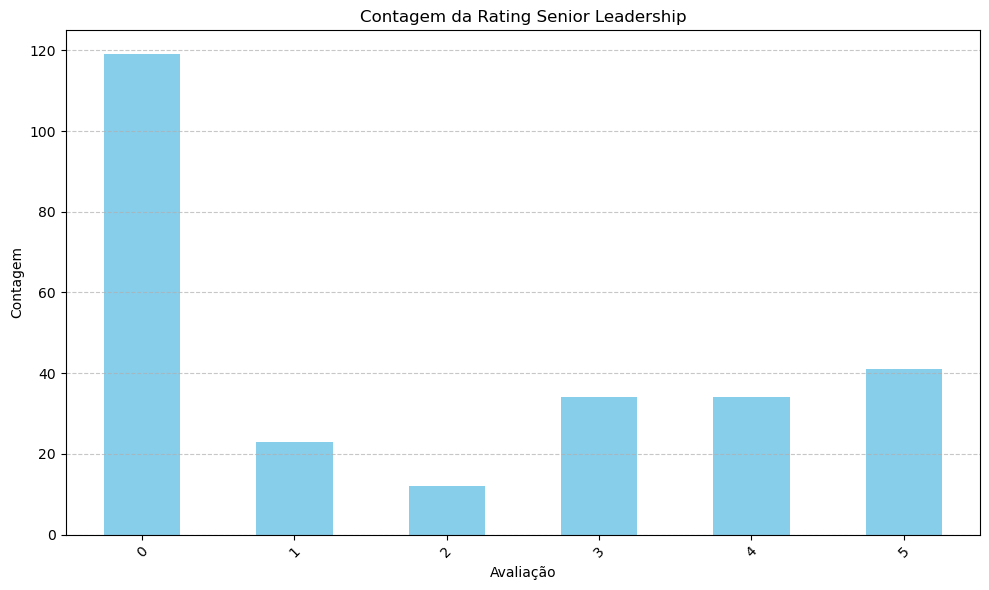

In [8]:
import matplotlib.pyplot as plt

coluna = 'Rating Senior Leadership'
# Rating Career Opportunities
# Rating Compensation and Benefits
# Rating Culture and Values
# Rating Diversity and Inclusion
# Rating Overall
# Rating Senior Leadership
# Rating Work Life Balance

# Verificando os dados da coluna 'Rating Career Opportunities'
career_opportunities_counts = df_[coluna].value_counts()
ordered_counts = career_opportunities_counts.reindex(range(6), fill_value=0)

# Criando o bar plot
plt.figure(figsize=(10, 6))
ordered_counts.plot(kind='bar', color='skyblue')
plt.title(f'Contagem da {coluna}')
plt.xlabel('Avaliação')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

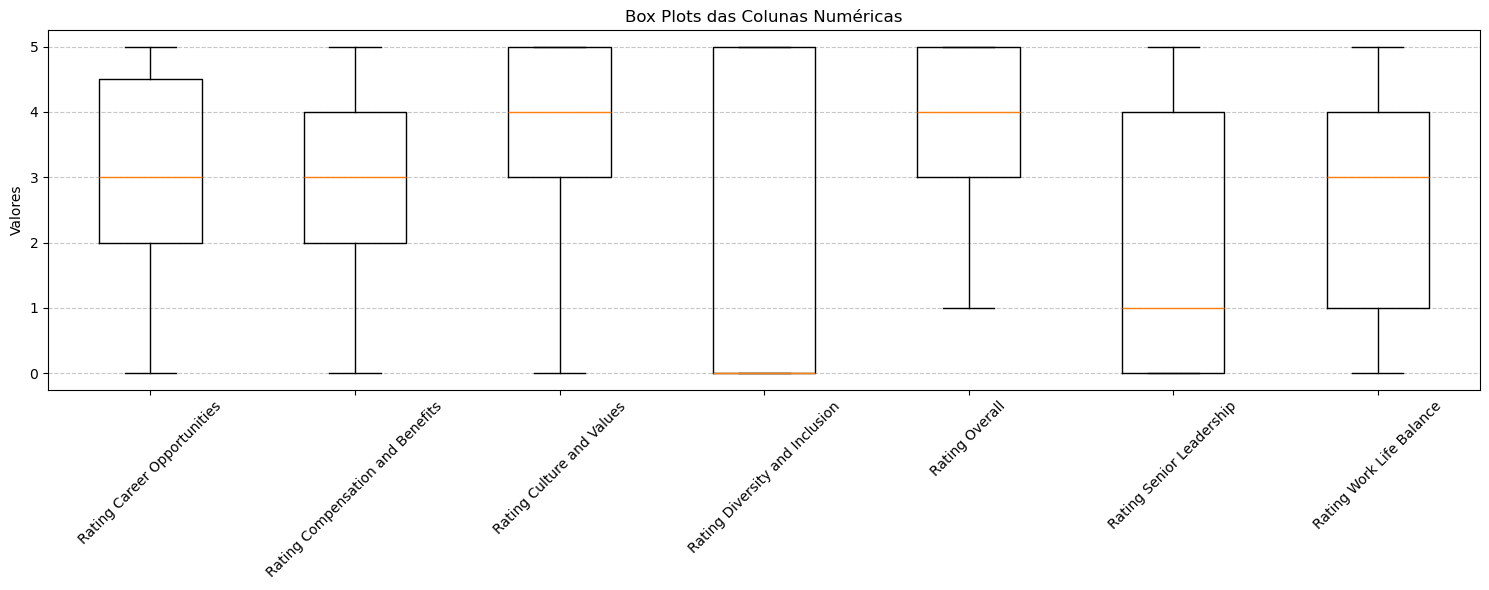

In [26]:
numerical_cols = df_.select_dtypes(include=['number']).columns
numerical_cols = numerical_cols[1:]
numerical_cols

plt.figure(figsize=(15, 6))

# Criando box plots para cada coluna numérica lado a lado
plt.boxplot([df_[col].dropna() for col in numerical_cols], labels=numerical_cols)

plt.title('Box Plots das Colunas Numéricas')
plt.ylabel('Valores')
plt.xticks(rotation=45)  # Girando os rótulos do eixo X para melhor visualização
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Adicionando grid
plt.tight_layout()  # Ajustando layout
plt.show()  # Exibindo os gráficos

#### Nulos

In [21]:
for colunas in df_.columns:
    df_nulos = df_[df_[colunas].isnull()]
    if df_nulos.empty:
        print(f"{colunas} não tem nulo")
    else:
        print(f"{colunas} tem nulo / Número de nulos: {df_nulos.shape[0]}")

Review ID não tem nulo
Contras não tem nulo
Pros não tem nulo
Cidade tem nulo / Número de nulos: 75
Job Title tem nulo / Número de nulos: 30
Rating Business Outlook tem nulo / Número de nulos: 133
Rating Career Opportunities não tem nulo
Rating Compensation and Benefits não tem nulo
Rating Culture and Values não tem nulo
Rating Diversity and Inclusion não tem nulo
Rating Overall não tem nulo
Rating Recommend to Friend tem nulo / Número de nulos: 36
Rating Senior Leadership não tem nulo
Rating Work Life Balance não tem nulo
Review Date Time não tem nulo
Summary não tem nulo


#### Correlações

C:\Users\andre\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


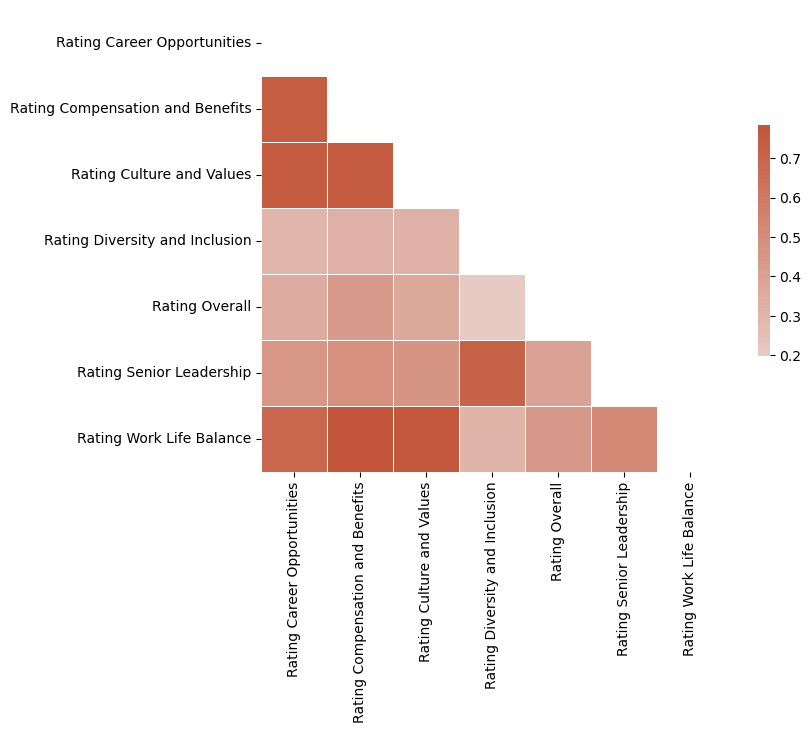

In [34]:
corr = df_[['Rating Career Opportunities', 'Rating Compensation and Benefits', 'Rating Culture and Values', 'Rating Diversity and Inclusion', 'Rating Overall', 'Rating Senior Leadership', 'Rating Work Life Balance']].corr()
 
mask = np.triu(np.ones_like(corr, dtype=bool)) 
 
f, ax = plt.subplots(figsize=(9, 6)) 
 
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);